# 0. Libraries

In [ ]:
!pip install datasets -q
!pip install transformers -q
!pip install sentencepiece -q
!pip install rouge -q
from datasets import load_dataset
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from transformers import BertTokenizer, BertModel, EncoderDecoderModel, AdamW,\
T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration,\
AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from functools import partial
import random
from sklearn.model_selection import train_test_split
from rouge import Rouge

# 1. Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeClare/joint_true_claims.csv')\
  .drop('Unnamed: 0', axis=1)
df.head()

,claim,text
0,Nikolaj Coster-Waldau worked with the Fox Broa...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...
1,Nikolaj Coster-Waldau worked with Peter Dinklage.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...
2,Nikolaj Coster-Waldau was in a film.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...
3,Game of Thrones (season 1) featured Danish act...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...
4,Nikolaj Coster-Waldau played Frank Pike in Vir...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...


In [ ]:
df.shape

(94846, 2)

# 2. Preprocess the data

## 2.1 Tokenizer

In [ ]:
# Define the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
i=0
for tokenizer in [bert_tokenizer, t5_tokenizer, bart_tokenizer]:
  print(i)
  i+=1
  print(tokenizer.cls_token)
  print(tokenizer.sep_token)
  print(tokenizer.mask_token)
  print(tokenizer.pad_token)

Using cls_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using mask_token, but it is not set yet.


0
[CLS]
[SEP]
[MASK]
[PAD]
1
None
None
None
<pad>
2
<s>
</s>
<mask>
<pad>


In [ ]:
i=0
for tokenizer in [bert_tokenizer, t5_tokenizer, bart_tokenizer]:
  print(i)
  i+=1
  print(tokenizer.cls_token_id)
  print(tokenizer.sep_token_id)
  print(tokenizer.mask_token_id)
  print(tokenizer.pad_token_id)

0
101
102
103
0
1
None
None
None
0
2
0
2
50264
1


In [ ]:
s1 = 'My name is Scott'
s2 = 'I love computer science'
i=0
for tokenizer in [bert_tokenizer, t5_tokenizer, bart_tokenizer]:
  print(i)
  i+=1
  print(tokenizer.encode(s1))
  print(tokenizer.encode(s2))
  print(s1+str(tokenizer.sep_token)+s2)
  print(tokenizer.encode(s1+str(tokenizer.sep_token)+s2))

Using sep_token, but it is not set yet.
Using sep_token, but it is not set yet.


0
[101, 2026, 2171, 2003, 3660, 102]
[101, 1045, 2293, 3274, 2671, 102]
My name is Scott[SEP]I love computer science
[101, 2026, 2171, 2003, 3660, 102, 1045, 2293, 3274, 2671, 102]
1
[499, 564, 19, 4972, 1]
[27, 333, 1218, 2056, 1]
My name is ScottNoneI love computer science
[499, 564, 19, 4972, 567, 782, 196, 333, 1218, 2056, 1]
2
[0, 2387, 766, 16, 1699, 2]
[0, 100, 657, 3034, 2866, 2]
My name is Scott</s>I love computer science
[0, 2387, 766, 16, 1699, 2, 100, 657, 3034, 2866, 2]


## 2.2 Mask claims by tokens

In [ ]:
def mask_token(sentence, tokenizer, p=0.5):
  tokens = tokenizer.tokenize(sentence)
  masked_tokens = [t if random.random()>p else tokenizer.mask_token
          for t in tokens]
  return tokenizer.convert_tokens_to_string(masked_tokens)
print(df.claim[0])
print(mask_token(df.claim[0], bert_tokenizer))
print(mask_token(df.claim[0], bart_tokenizer))

Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
[MASK]j [MASK] [MASK] - wal [MASK]u [MASK] with [MASK] [MASK] [MASK] company [MASK]
Nik<mask><mask><mask><mask><mask><mask><mask><mask><mask><mask> the Fox Broadcasting<mask><mask>


In [ ]:
df['masked_claim'] = df.claim.apply(
    partial(mask_token, tokenizer=bart_tokenizer))
df.head()

,claim,text,masked_claim
0,Nikolaj Coster-Waldau worked with the Fox Broa...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask>aj<mask>oster-<mask><mask>au worke...
1,Nikolaj Coster-Waldau worked with Peter Dinklage.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...
2,Nikolaj Coster-Waldau was in a film.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask><mask> Coster-<mask>ald<mask> was<...
3,Game of Thrones (season 1) featured Danish act...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask> of<mask> (<mask> 1) featured<mask> acto...
4,Nikolaj Coster-Waldau played Frank Pike in Vir...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...


## 2.3 Concatenate inputs

In [ ]:
df['input'] = df['masked_claim'] + bart_tokenizer.sep_token + df['text']

In [ ]:
df.input[0]

"<mask><mask>aj<mask>oster-<mask><mask>au worked<mask><mask> Fox Broadcasting Company<mask></s>Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter . He graduated from Danish National School of Theatre in Copenhagen in 1993 . Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- . Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .   In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . He became widely kno

## 2.4 Tokenize input and targets

In [ ]:
sample_encode = bart_tokenizer(df.input[0],max_length=64,padding="max_length",
                          truncation=True, return_tensors="pt")
print(sample_encode.keys())
print(sample_encode['input_ids'])
print(sample_encode['attention_mask'])

dict_keys(['input_ids', 'attention_mask'])
tensor([[    0, 50264, 50264,  1176, 50264, 13991,    12, 50264, 50264,  1180,
          1006, 50264, 50264,  2063, 13610,  1260, 50264,     2, 38334,  1168,
          1176,   230, 13991,    12,   771,  5618,  1180,   111,   574, 26770,
            12,   111, 10463,   387,    12,  3087, 35423,  5543, 44025, 27969,
          3019, 35423, 10278, 44025, 10965,   449, 38155,  7487, 38155, 14285,
         28045, 44025,  8210, 35423, 16948,  1437, 49066, 38155, 13859,  5618,
         44025,  8210, 35423,     2]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
def ids_and_mask_encode(s,tokenizer,max_length=512):
  encoding=tokenizer(s,max_length=max_length,padding="max_length",
                          truncation=True)
  return encoding['input_ids']

In [ ]:
sample_series_encode = df.input[:10].apply(partial(bart_tokenizer.encode
                          ,max_length=512,padding="max_length",
                          truncation=True))

In [ ]:
print(sample_series_encode[0])

[0, 50264, 50264, 1176, 50264, 13991, 12, 50264, 50264, 1180, 1006, 50264, 50264, 2063, 13610, 1260, 50264, 2, 38334, 1168, 1176, 230, 13991, 12, 771, 5618, 1180, 111, 574, 26770, 12, 111, 10463, 387, 12, 3087, 35423, 5543, 44025, 27969, 3019, 35423, 10278, 44025, 10965, 449, 38155, 7487, 38155, 14285, 28045, 44025, 8210, 35423, 16948, 1437, 49066, 38155, 13859, 5618, 44025, 8210, 35423, 3602, 38155, 27969, 44025, 10965, 111, 8105, 387, 12, 25606, 2421, 974, 550, 6200, 111, 25733, 387, 12, 16, 10, 13501, 2701, 2156, 3436, 8, 2441, 9408, 479, 91, 8505, 31, 13501, 496, 835, 9, 5132, 11, 22843, 11, 9095, 479, 230, 13991, 12, 771, 5618, 1180, 128, 29, 10118, 819, 11, 10060, 21, 39, 774, 11, 5, 822, 4172, 11018, 111, 574, 26770, 12, 8148, 111, 25733, 387, 12, 479, 1773, 172, 37, 34, 1382, 11, 3617, 3541, 11, 39, 3763, 39403, 493, 8, 1005, 11, 937, 2156, 217, 3928, 18458, 2696, 111, 574, 26770, 12, 1466, 111, 25733, 387, 12, 8, 83, 24359, 1513, 2497, 4172, 111, 574, 26770, 12, 1014, 111, 257

In [ ]:
lengths = df.input.apply(lambda x: len(x.split()))

6
1504
319.58868059802205
288.0


<Axes: ylabel='Frequency'>

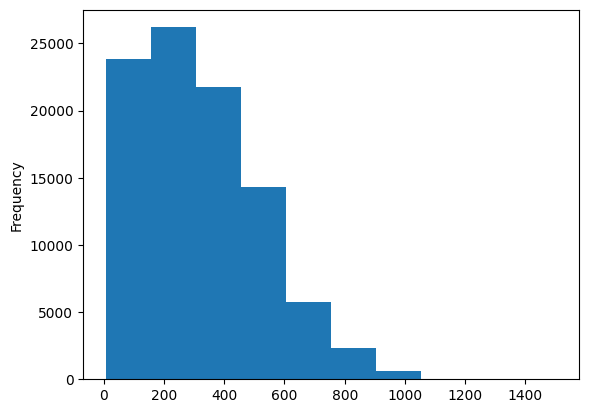

In [ ]:
print(lengths.min())
print(lengths.max())
print(lengths.mean())
print(lengths.median())
lengths.plot.hist()

In [ ]:
# df[['input_ids', 'input_mask']] = df.input.apply(lambda x: 
#                           pd.Series(ids_and_mask_encode(x,
#                           tokenizer=tokenizer,max_length=1024)))
df['input_tokens'] = df.input.apply(partial(bart_tokenizer.encode
                          ,max_length=512,padding="max_length",
                          truncation=True))
df.head()

,claim,text,masked_claim,input,input_tokens
0,Nikolaj Coster-Waldau worked with the Fox Broa...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,"[0, 50264, 50264, 1176, 50264, 13991, 12, 5026..."
1,Nikolaj Coster-Waldau worked with Peter Dinklage.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,"[0, 38334, 1168, 1176, 230, 50264, 50264, 771,..."
2,Nikolaj Coster-Waldau was in a film.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,"[0, 50264, 50264, 50264, 230, 13991, 12, 50264..."
3,Game of Thrones (season 1) featured Danish act...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask> of<mask> (<mask> 1) featured<mask> acto...,<mask> of<mask> (<mask> 1) featured<mask> acto...,"[0, 50264, 9, 50264, 36, 50264, 112, 43, 3520,..."
4,Nikolaj Coster-Waldau played Frank Pike in Vir...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,"[0, 38334, 50264, 1176, 50264, 50264, 12, 5026..."


In [ ]:
df.to_csv('/content/drive/MyDrive/DeClare/only_input_encoded_base_512.csv', index=False)

In [ ]:
df['claim_tokens'] = df.claim.apply(partial(bart_tokenizer.encode
                          ,max_length=32,padding="max_length",
                          truncation=True))
df.head()

,claim,text,masked_claim,input,input_tokens,claim_tokens
0,Nikolaj Coster-Waldau worked with the Fox Broa...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,"[0, 50264, 50264, 1176, 50264, 13991, 12, 5026...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
1,Nikolaj Coster-Waldau worked with Peter Dinklage.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,"[0, 38334, 1168, 1176, 230, 50264, 50264, 771,...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
2,Nikolaj Coster-Waldau was in a film.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,"[0, 50264, 50264, 50264, 230, 13991, 12, 50264...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
3,Game of Thrones (season 1) featured Danish act...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask> of<mask> (<mask> 1) featured<mask> acto...,<mask> of<mask> (<mask> 1) featured<mask> acto...,"[0, 50264, 9, 50264, 36, 50264, 112, 43, 3520,...","[0, 20178, 9, 13480, 36, 4162, 112, 43, 3520, ..."
4,Nikolaj Coster-Waldau played Frank Pike in Vir...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,"[0, 38334, 50264, 1176, 50264, 50264, 12, 5026...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."


In [ ]:
df.to_csv('/content/drive/MyDrive/DeClare/input_and_claim_encoded_base_512.csv', index=False)

## 2.5 Split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeClare/input_and_claim_encoded_base_512.csv')
df.head()

,claim,text,masked_claim,input,input_tokens,claim_tokens
0,Nikolaj Coster-Waldau worked with the Fox Broa...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,<mask><mask>aj<mask>oster-<mask><mask>au worke...,"[0, 50264, 50264, 1176, 50264, 13991, 12, 5026...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
1,Nikolaj Coster-Waldau worked with Peter Dinklage.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,Nikolaj C<mask><mask>W<mask><mask><mask><mask>...,"[0, 38334, 1168, 1176, 230, 50264, 50264, 771,...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
2,Nikolaj Coster-Waldau was in a film.,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,<mask><mask><mask> Coster-<mask>ald<mask> was<...,"[0, 50264, 50264, 50264, 230, 13991, 12, 50264...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."
3,Game of Thrones (season 1) featured Danish act...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,<mask> of<mask> (<mask> 1) featured<mask> acto...,<mask> of<mask> (<mask> 1) featured<mask> acto...,"[0, 50264, 9, 50264, 36, 50264, 112, 43, 3520,...","[0, 20178, 9, 13480, 36, 4162, 112, 43, 3520, ..."
4,Nikolaj Coster-Waldau played Frank Pike in Vir...,Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰ...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,Nik<mask>aj<mask><mask>-<mask>aldau<mask> Fran...,"[0, 38334, 50264, 1176, 50264, 50264, 12, 5026...","[0, 38334, 1168, 1176, 230, 13991, 12, 771, 56..."


In [ ]:
for col in ['input_tokens', 'claim_tokens']:
  df[col] = df[col].apply(eval)

In [ ]:
input_tokens, claim_tokens = df.input_tokens.to_list(), df.claim_tokens.to_list()
train_input, val_input, train_claim, val_claim = train_test_split(
    input_tokens, claim_tokens, test_size=0.2, random_state=42)
val_input, test_input, val_claim, test_claim = train_test_split(
    val_input, val_claim, test_size=0.5, random_state=42)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_input = torch.tensor(train_input).to(device)
train_claim = torch.tensor(train_claim).to(device)
val_input = torch.tensor(val_input).to(device)
val_claim = torch.tensor(val_claim).to(device)
test_input = torch.tensor(test_input).to(device)
test_claim = torch.tensor(test_claim).to(device)

# 3. Fine tune the model

## 3.1 Try predicting the claim

In [ ]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)

In [ ]:
sample_input_tensor = train_input[:1]
sample_input_tensor

tensor([[    0, 42268, 50264, 27413,  2865, 50264,    19,    41,  2701,     4,
             2, 40422, 13065,   268,    16,    10,  1824,  2222,   822,  1982,
            30,  4578,  1775,   493,  2156,  3660,    30,  2363,   287,   611,
          2156,     8,  8996, 10716, 27413,  2865,  2156,  3289,  1731, 12037,
          2156,  6416,  7274, 21651,  2156,  6937,  8336,  2420, 12425,  2156,
          1209,    12, 43691,     8,  3262,   274, 33306,   479,  8427, 13065,
           268,    16,  4083,    30,  3031,  1061,    11,     5,   628, 40176,
         25620,    77,  6233,   808,   636,  8609,    58, 14577,    25,   475,
         17773,     7, 29132,   459, 37695,    31,  1005,    88,     5,   315,
           532,   479,  1437,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
model_output=model.generate(sample_input_tensor)

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
bart_tokenizer.decode(model_output[0])

'</s><s>Jesse Eisenberg in a scene with an actor.</s>'

## 3.2 Rouge loss

In [ ]:
# Define the ROUGE scorer
rouge = Rouge()

# Define the custom loss function
def rouge_loss(y_true, y_pred):
    # Convert the token IDs to text
    y_true_text = bart_tokenizer.decode(y_true.squeeze(), skip_special_tokens=True)
    y_pred_text = bart_tokenizer.decode(y_pred.squeeze(), skip_special_tokens=True)
    
    # Compute the ROUGE score between the predicted and true summaries
    scores = rouge.get_scores(y_pred_text, y_true_text)
    rouge_score = scores[0]['rouge-l']['f']
    
    # Compute the loss as 1 - ROUGE score
    loss = 1 - rouge_score
    
    return loss

In [ ]:
model_output[0]

tensor([    2,     0, 42268,  1090, 27413,  2865,    11,    10,  1310,    19,
           41,  2701,     4,     2])

In [ ]:
train_claim[0]

tensor([    0, 42268,  1090, 27413,  2865,  1006,    19,    41,  2701,     4,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])

In [ ]:
rouge_loss(model_output[0], train_claim[0])

0.28571429061224485

In [ ]:
rouge_loss(train_claim[0], train_claim[0])

4.999999969612645e-09

## 3.3 Dataset and Dataloader

In [ ]:
batch_size=64

In [ ]:
train_data = TensorDataset(train_input, train_claim)
val_data = TensorDataset(val_input, val_claim)
test_data = TensorDataset(test_input, test_claim)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## 3.4 Fine tune

In [ ]:
num_epochs = 3

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_loss_list = []
val_loss_list = []

In [ ]:
# model = model.to(device)
model.train()
None

In [ ]:
for epoch in range(num_epochs):
    train_loss = 0
    for input_batch, claim_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids=input_batch, labels=claim_batch)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
    
    val_loss = 0
    with torch.no_grad():
        for input_batch, claim_batch in val_loader:
            outputs = model(input_ids=input_batch, labels=claim_batch)
            loss = outputs[0]
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Epoch 1: Train Loss = 0.3507, Val Loss = 0.1684
Epoch 2: Train Loss = 0.1396, Val Loss = 0.1501
Epoch 3: Train Loss = 0.1139, Val Loss = 0.1422


In [ ]:
model.save_pretrained('/content/drive/MyDrive/DeClare/models/2023-04-05-16-44')

In [ ]:
test_loss = 0
with torch.no_grad():
    for input_batch, claim_batch in test_loader:
        outputs = model(input_ids=input_batch, labels=claim_batch)
        loss = outputs[0]
        test_loss += loss.item()
    test_loss /= len(test_loader)

In [ ]:
print(f'Test Loss = {test_loss:.4f}')

Test Loss = 0.1412


## 3.5 Test it out!

In [ ]:
model.eval()
None

In [ ]:
claim = df.claim[0]
text = df.text[0]
print(claim)
print(text)

Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter . He graduated from Danish National School of Theatre in Copenhagen in 1993 . Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- . Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .   In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . He became widely known to a broad audience for his 

In [ ]:
num_of_masked_sample = 5

In [ ]:
def pipeline(input_str):
  input_tokens = torch.tensor([bart_tokenizer.encode(input_str)]).to(device)
  output_tokens = model.generate(input_tokens)
  output_str = bart_tokenizer.decode(output_tokens[0], skip_special_tokens=True)
  return output_str

Mask Probability =0.5

In [ ]:
masked_list = [mask_token(claim, bart_tokenizer, 0.5) for i in range(num_of_masked_sample)]
for i in range(num_of_masked_sample):
  print(masked_list[i])

<mask>ol<mask> Coster-Wald<mask><mask> with the Fox Broadcasting Company<mask>
<mask>ol<mask> Coster<mask>Wald<mask> worked with the Fox Broadcasting Company<mask>
Nikol<mask> Coster<mask>Waldau worked<mask> the Fox<mask><mask>.
Nik<mask><mask><mask>oster-W<mask>au worked with<mask><mask><mask><mask>.
<mask>olaj Coster<mask>Waldau worked<mask><mask> Fox Broadcasting Company<mask>


In [ ]:
input_list = [masked_claim + bart_tokenizer.sep_token + 
              text for masked_claim in masked_list]

In [ ]:
print('Original claim: ' + claim)
for i in range(num_of_masked_sample):
  print('Regenerated claim', i, 
        pipeline(input_list[i]))

Original claim: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Regenerated claim 0 Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Regenerated claim 1 Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Regenerated claim 2 Nikolaj Coster-Waldau worked on the Fox television series.
Regenerated claim 3 Nikolaj Coster-Waldau worked with an American screenwriter.
Regenerated claim 4 Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.


Mask Probability =0.7

In [ ]:
masked_list = [mask_token(claim, bart_tokenizer, 0.7) for i in range(num_of_masked_sample)]
for i in range(num_of_masked_sample):
  print(masked_list[i])

<mask><mask><mask><mask><mask><mask>Waldau<mask> with<mask><mask><mask><mask><mask>
<mask><mask>aj<mask>oster<mask><mask><mask><mask> worked<mask><mask> Fox<mask> Company<mask>
<mask>ol<mask><mask>oster<mask>W<mask><mask> worked with<mask> Fox<mask><mask>.
<mask><mask>aj<mask><mask><mask><mask>ald<mask> worked<mask> the Fox<mask><mask><mask>
<mask>olaj C<mask>-Wald<mask><mask><mask><mask><mask><mask> Company<mask>


In [ ]:
input_list = [masked_claim + bart_tokenizer.sep_token + 
              text for masked_claim in masked_list]

In [ ]:
print('Original claim: ' + claim)
for i in range(num_of_masked_sample):
  print('Regenerated claim', i, 
        pipeline(input_list[i]))

Original claim: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Regenerated claim 0 Nikolaj Coster-Waldau worked with a Danish screenwriter.
Regenerated claim 1 Nikolaj Coster-Waldau worked with the Fox Film Company.
Regenerated claim 2 Nikolaj Coster-Waldau worked with the Fox television series.
Regenerated claim 3 Nikolaj Coster-Waldau worked on the Fox television series.
Regenerated claim 4 Nikolaj Coster-Waldau worked with the Walt Disney Company.
